Processing file: https://raw.githubusercontent.com/humdrum-tools/bach-wtc-fugues/refs/heads/master/kern/wtc1f01.krn



,Measure,Local Onset,Global Onset,Duration,Pitch,MIDI
0,1,0.50,0.50,0.500,C4,60
1,1,1.00,1.00,0.500,D4,62
2,1,1.50,1.50,0.500,E4,64
3,1,2.00,2.00,0.750,F4,65
4,1,2.75,2.75,0.125,G4,67
...,...,...,...,...,...,...
787,27,1.50,105.50,0.500,D5,74
788,27,1.75,105.75,0.250,B5,83
789,27,2.00,106.00,2.000,C6,84
790,27,2.00,106.00,2.000,G5,79


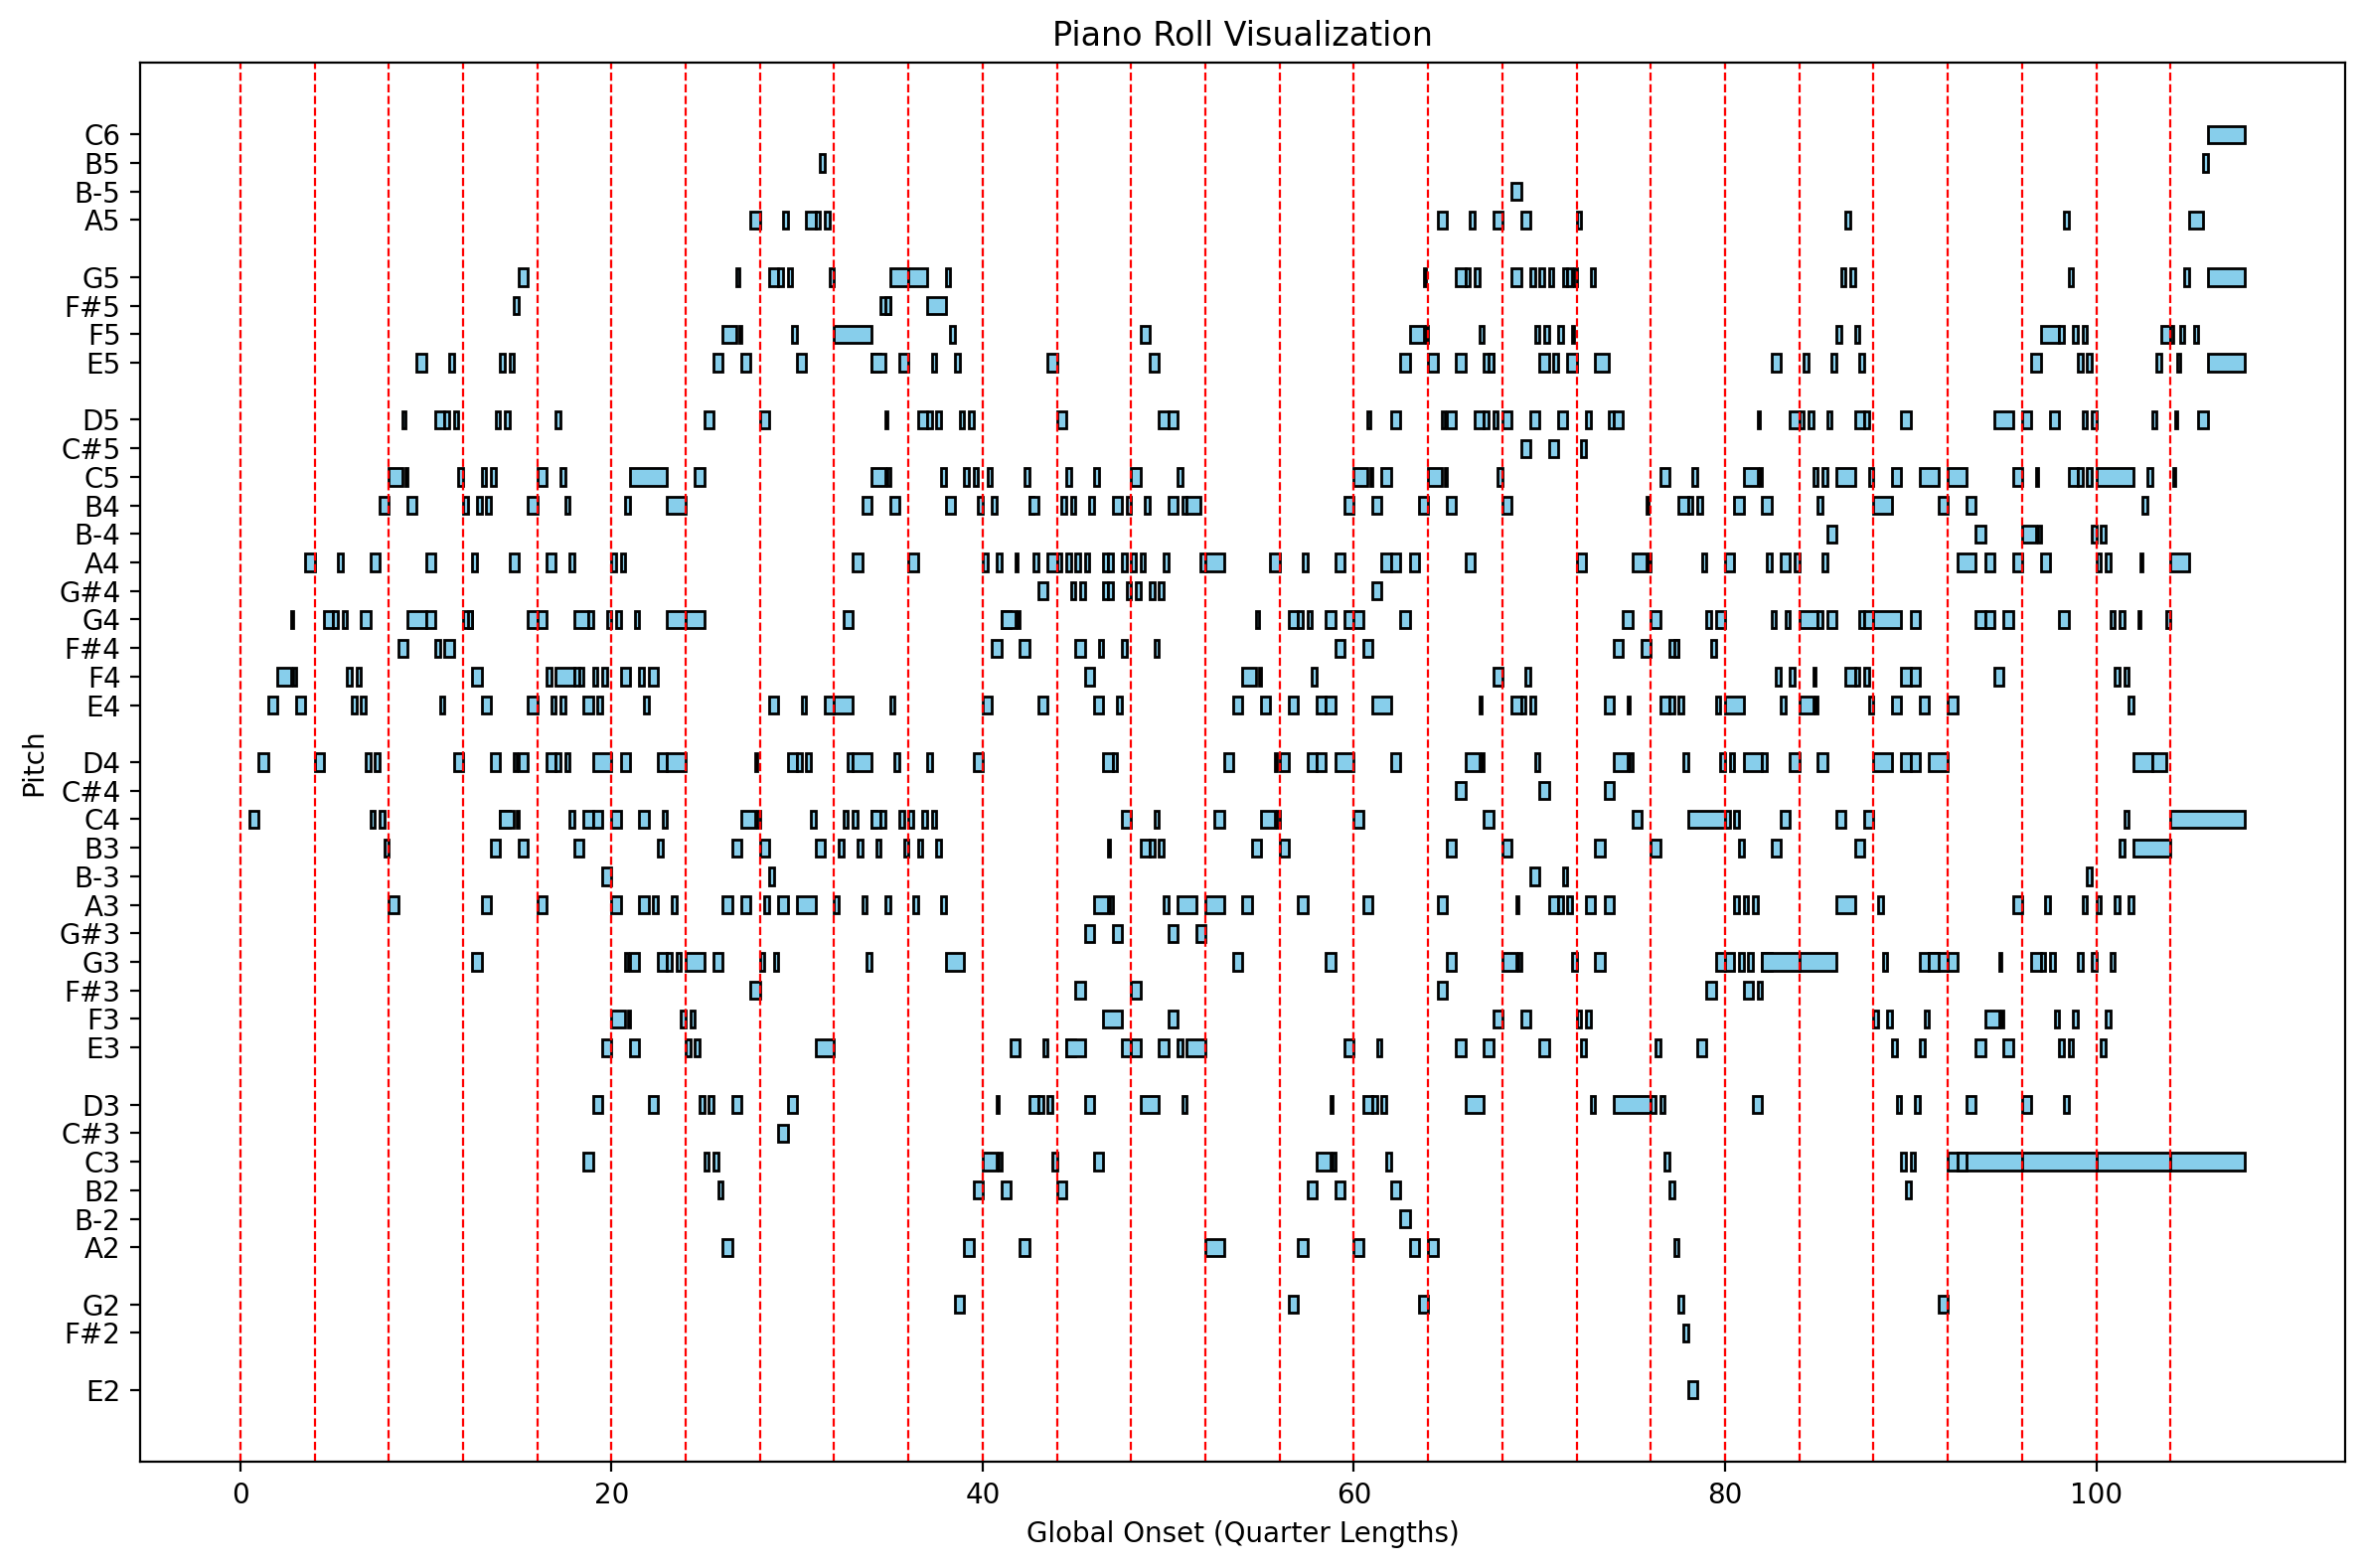

In [1]:
# Import necessary libraries
import os
import tempfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
from music21 import converter, note, chord, pitch as pitch_module
from IPython.display import display

# Function to get the local file path from a URL or verify a local path
def get_file_path(file_source):
    """
    Determines if file_source is a URL or a local path.
    Downloads the file if it's a URL and returns the local path.
    Verifies and returns the path if it's a local file.

    Parameters
    ----------
    file_source : str
        URL or local file path.

    Returns
    -------
    str
        Local file path.

    Raises
    ------
    ValueError
        If there's an issue downloading the file.
    FileNotFoundError
        If the local file does not exist.
    """
    if file_source.startswith(('http://', 'https://')):
        try:
            response = requests.get(file_source, stream=True)
            response.raise_for_status()
            _, file_extension = os.path.splitext(file_source)
            temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=file_extension)
            with temp_file as tf:
                tf.write(response.content)
            return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError(f"Local file does not exist: {file_source}")

# Function to extract voice data from the score
def extract_voice_data(score):
    """
    Extracts measure number, global onset, local onset, duration, and pitch from a music21 score.

    Parameters
    ----------
    score : music21.stream.Score
        The music21 score object.

    Returns
    -------
    list of tuples
        Each tuple contains (Measure, Local Onset, Global Onset, Duration, Pitch).
    """
    voice_data = []
    notes_and_chords = score.flatten().notesAndRests.stream()

    for element in notes_and_chords:
        if isinstance(element, (note.Note, chord.Chord)):
            # Get the measure context
            measure = element.getContextByClass('Measure')
            if measure is not None:
                measure_num = measure.number
                measure_offset = measure.offset
            else:
                # If measure context is not found, default to 0
                measure_num = 0
                measure_offset = 0.0

            global_onset = element.offset
            local_onset = global_onset - measure_offset
            duration = element.duration.quarterLength

            # Handle notes and chords
            if isinstance(element, note.Note):
                pitches = [str(element.pitch)]
            else:
                pitches = [str(p) for p in element.pitches]

            # Append data for each pitch
            voice_data.extend([
                (measure_num, local_onset, global_onset, duration, pitch)
                for pitch in pitches
            ])

    return voice_data

# Function to create a piano roll plot with measure lines
def create_piano_roll(df, measure_offsets=None):
    """
    Generates a piano roll visualization from the DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch', and 'MIDI'.
    measure_offsets : list of floats, optional
        List of global onset times where measures start. If provided, vertical lines will be drawn at these positions.
    """
    # Ensure unique MIDI to pitch mapping
    midi_to_pitch = df.drop_duplicates('MIDI').set_index('MIDI')['Pitch'].to_dict()

    plt.figure(figsize=(12, 8))
    for _, row in df.iterrows():
        plt.barh(
            row['MIDI'],
            width=row['Duration'],
            left=row['Global Onset'],
            height=0.6,
            color='skyblue',
            edgecolor='black'
        )

    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Global Onset (Quarter Lengths)')
    plt.ylabel('Pitch')
    plt.title('Piano Roll Visualization')

    # Draw measure lines if measure offsets are provided
    if measure_offsets is not None:
        for m_offset in measure_offsets:
            plt.axvline(x=m_offset, color='red', linestyle='--', linewidth=0.8)

    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to filter and adjust durations in the DataFrame
def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """
    Filters out zero-duration notes and adjusts fractional durations.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame.
    filter_zero_duration : bool, optional
        If True, removes rows with Duration <= 0. Default is True.
    adjust_fractional_duration : bool, optional
        If True, rounds 'Duration', 'Local Onset', and 'Global Onset' to 3 decimal places. Default is True.

    Returns
    -------
    pandas.DataFrame
        Processed DataFrame.
    """
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        df_processed['Duration'] = df_processed['Duration'].round(3)
        df_processed['Local Onset'] = df_processed['Local Onset'].round(3)
        df_processed['Global Onset'] = df_processed['Global Onset'].round(3)

    return df_processed

# Configuration flags
FILTER_ZERO_DURATION = True        # Set to False to include zero-duration notes
ADJUST_FRACTIONAL_DURATION = True  # Set to False to keep original durations

# List of file sources (URLs or local paths)
file_sources = [
    #'https://analyse.hfm-weimar.de/database/02/PrJode_Jos0302_COM_1-5_MissaDapac_002_00006.xml',
    'https://raw.githubusercontent.com/humdrum-tools/bach-wtc-fugues/refs/heads/master/kern/wtc1f01.krn'
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei'
    # Add more file sources as needed
]

# Processing loop
for file_source in file_sources:
    try:
        print(f"Processing file: {file_source}\n")

        # Get the local file path
        file_path = get_file_path(file_source)

        # Parse the music file
        score = converter.parse(file_path)

        # Extract voice data
        voice_data = extract_voice_data(score)

        # Create DataFrame with specified column order
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch'])
        df = df[['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch']]

        # Convert Pitch to MIDI with error handling
        try:
            df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        except Exception as e:
            print(f"Error converting pitch to MIDI: {e}")
            continue

        # Process the DataFrame
        df_processed = filter_and_adjust_durations(
            df,
            filter_zero_duration=FILTER_ZERO_DURATION,
            adjust_fractional_duration=ADJUST_FRACTIONAL_DURATION
        )

        # Display the processed DataFrame
        display(df_processed)

        # Get measure offsets for drawing measure lines
        # Assuming all parts have the same measure structure
        measures = score.parts[0].getElementsByClass('Measure')
        measure_offsets = [measure.offset for measure in measures]

        # Create the piano roll visualization with measure lines
        create_piano_roll(df_processed, measure_offsets=measure_offsets)

        # Optionally, delete the temporary file if it was downloaded
        if file_source.startswith(('http://', 'https://')):
            os.remove(file_path)

    except Exception as e:
        print(f"An error occurred while processing {file_source}: {e}\n")


In [3]:
# Import Bokeh libraries
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Span, LinearColorMapper, ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
import pandas as pd

# Initialize Bokeh to display plots in the notebook
output_notebook()

# Ensure df_processed exists and has the required columns
# If not, run the previous cells to create df_processed

# Example:
# display(df_processed.head())

# Create a sorted list of unique MIDI pitches
unique_midi = sorted(df_processed['MIDI'].unique())
# Create a mapping from MIDI to pitch names
midi_to_pitch = {midi: pitch for midi, pitch in zip(df_processed['MIDI'], df_processed['Pitch'])}

# Create an 'End' column representing the end of each note
df_processed['End'] = df_processed['Global Onset'] + df_processed['Duration']

# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(df_processed)

# Define the range for the y-axis based on MIDI numbers
y_range = (min(unique_midi) - 1, max(unique_midi) + 1)

# Define the range for the x-axis based on global onset and durations
x_min = 0
x_max = df_processed['End'].max() + 1  # Added 1 for some padding

# Create the figure with corrected height and width parameters
p = figure(
    title="Piano Roll Visualization (Bokeh)",
    x_axis_label='Global Onset (Quarter Lengths)',
    y_axis_label='Pitch',
    y_range=(min(unique_midi) - 1, max(unique_midi) + 1),
    height=600,        # Corrected from 'plot_height' to 'height'
    width=1000,         # Corrected from 'plot_width' to 'width'
    tools="pan,wheel_zoom,box_zoom,reset,save",
    toolbar_location="above",
    x_range=(x_min, x_max)
)

# Add horizontal bars for each note
hbars = p.hbar(
    y='MIDI',
    height=0.6,  # Adjust the height of the bars
    left='Global Onset',
    right='End',  # Changed from 'Global Onset + Duration' to 'End'
    source=source,
    fill_color=linear_cmap('MIDI', Viridis256, min(unique_midi), max(unique_midi)),
    line_color='black',
    alpha=0.7,
)

# Set y-axis ticks to show pitch names instead of MIDI numbers
p.yaxis.ticker = unique_midi
p.yaxis.major_label_overrides = {midi: midi_to_pitch[midi] for midi in unique_midi}

# Add a color bar to indicate MIDI pitch mapping
color_mapper = LinearColorMapper(palette=Viridis256, low=min(unique_midi), high=max(unique_midi))
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='MIDI Pitch')
p.add_layout(color_bar, 'right')

# Add a variable to toggle measure lines on/off
show_measure_lines = True  # Set to False to hide measure lines

# Add measure lines if measure_offsets are provided and if show_measure_lines is True
if show_measure_lines and 'measure_offsets' in globals() and measure_offsets:
    for m_offset in measure_offsets:
        measure_line = Span(location=m_offset, dimension='height', line_color='red', line_dash='dashed', line_width=1)
        p.add_layout(measure_line)


# Add a hover tool to display note details
hover = HoverTool(
    tooltips=[
        ("Measure", "@Measure"),
        ("Pitch", "@Pitch"),
        ("Local Onset", "@{Local Onset}"),
        ("Global Onset", "@{Global Onset}"),
        ("Duration", "@Duration"),
    ],
    renderers=[hbars],
)

p.add_tools(hover)

# Display the plot
show(p)


Loading BokehJS ...

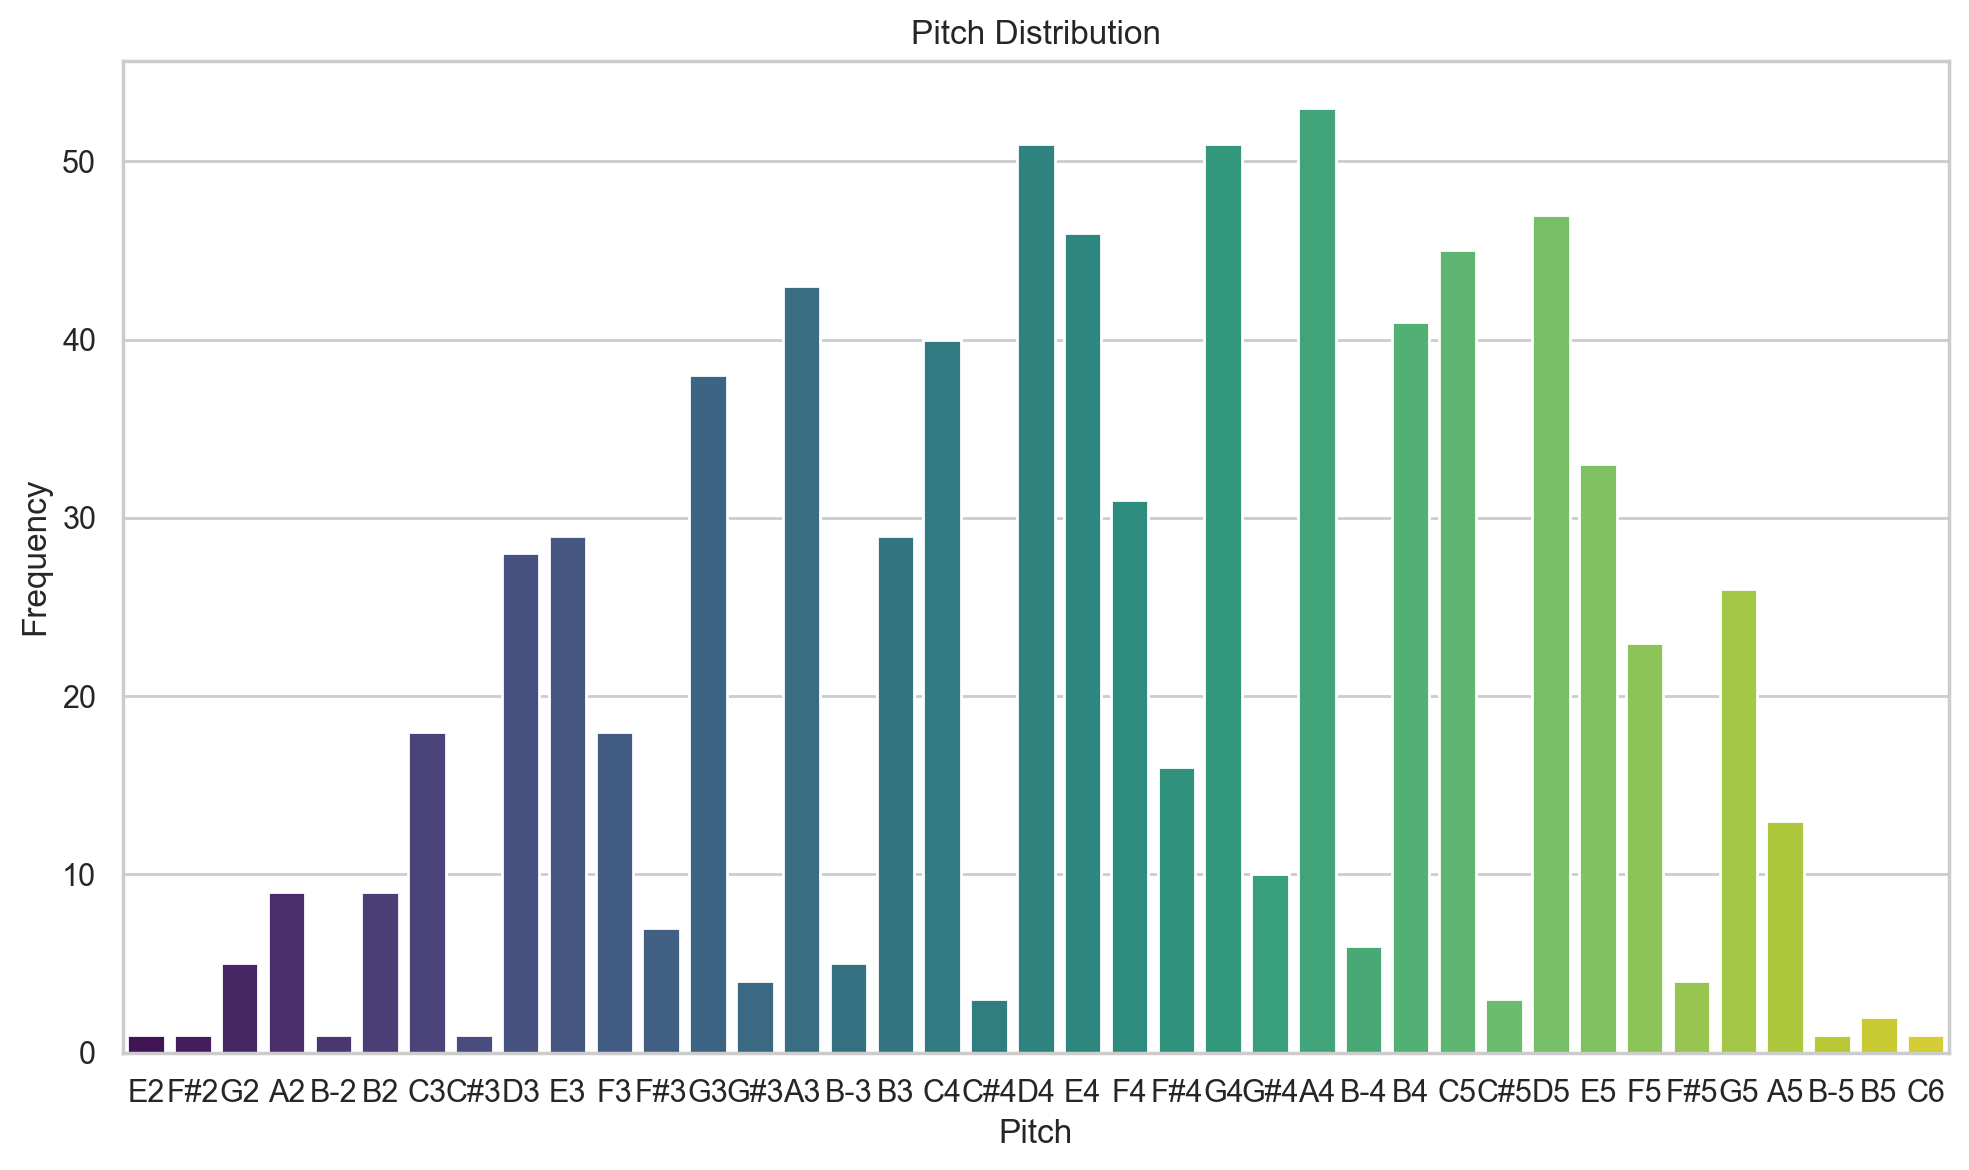

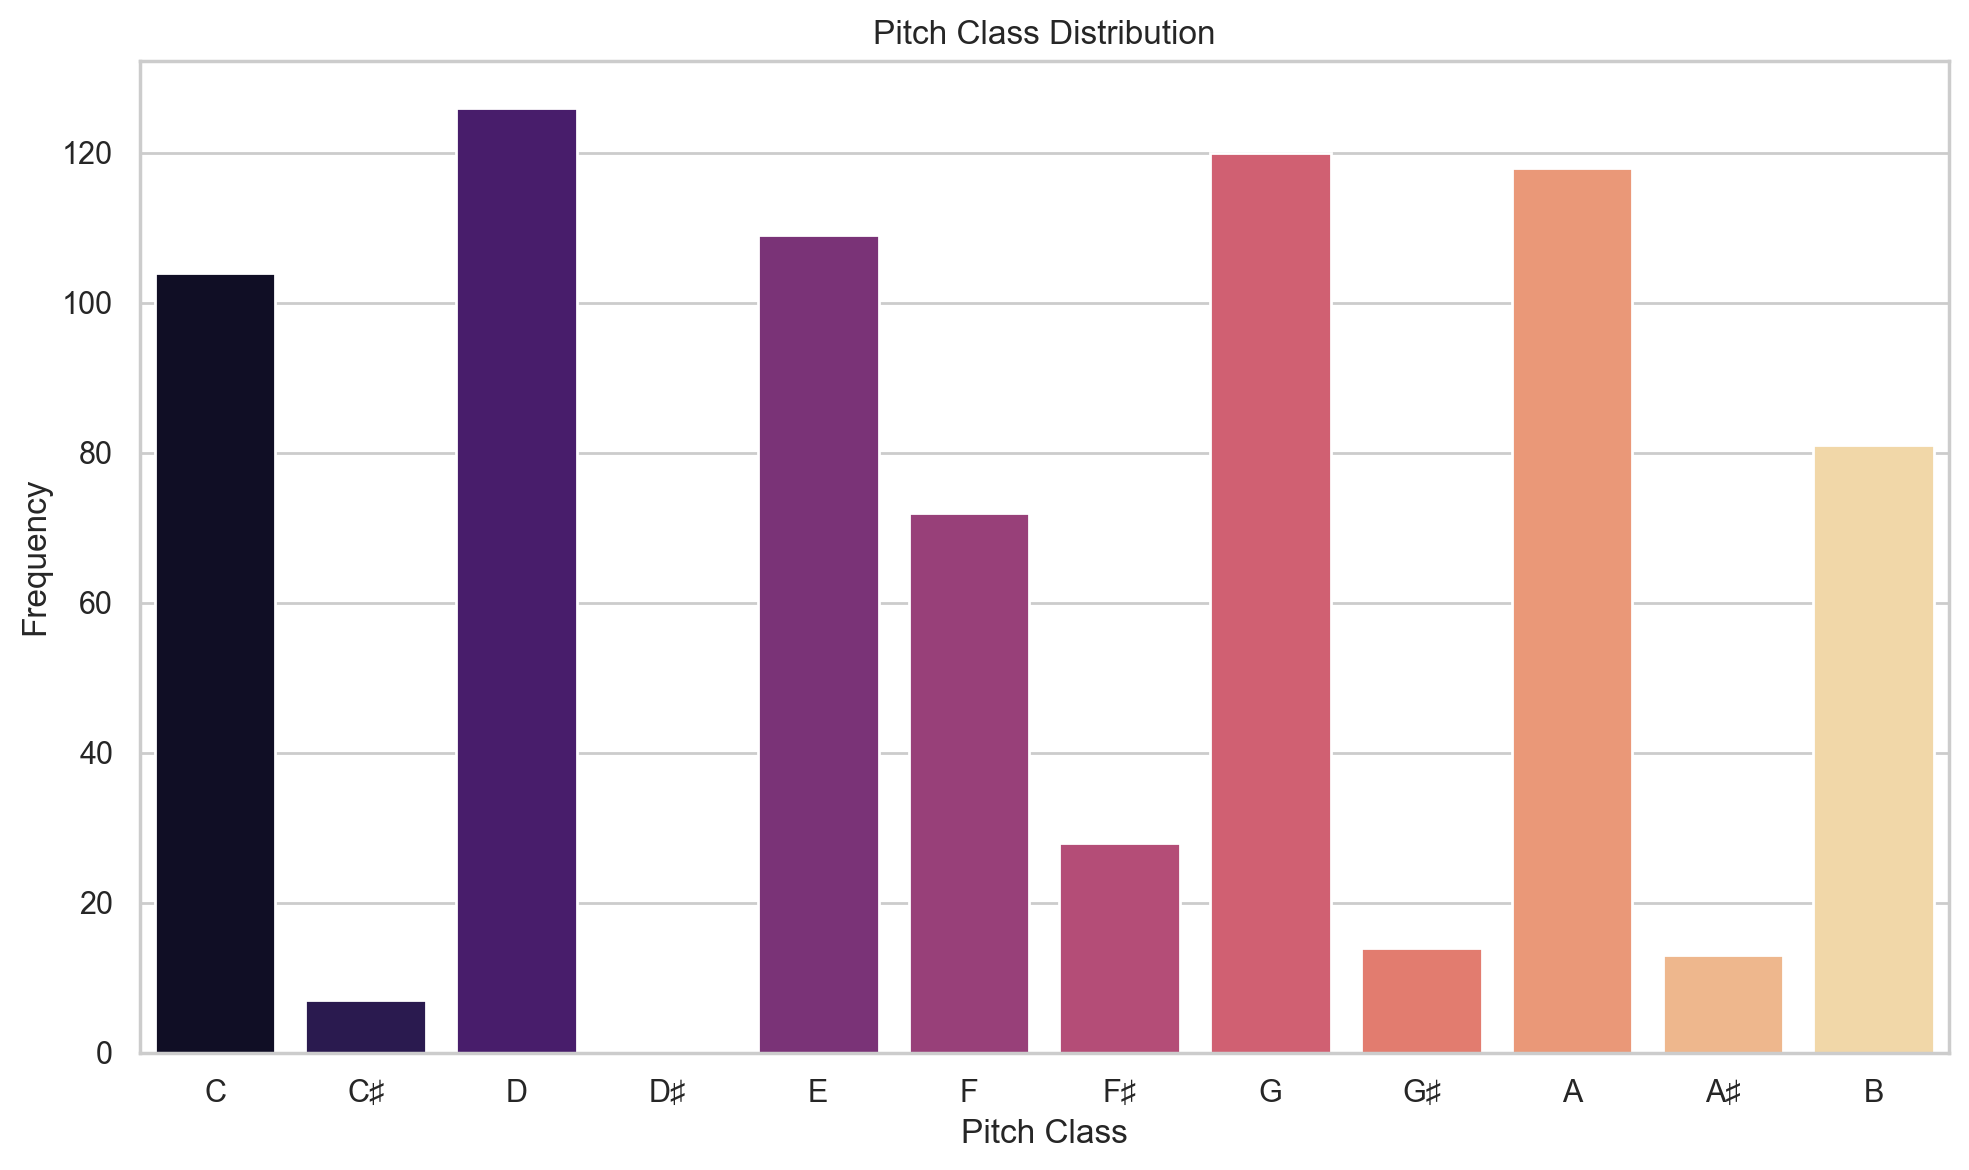

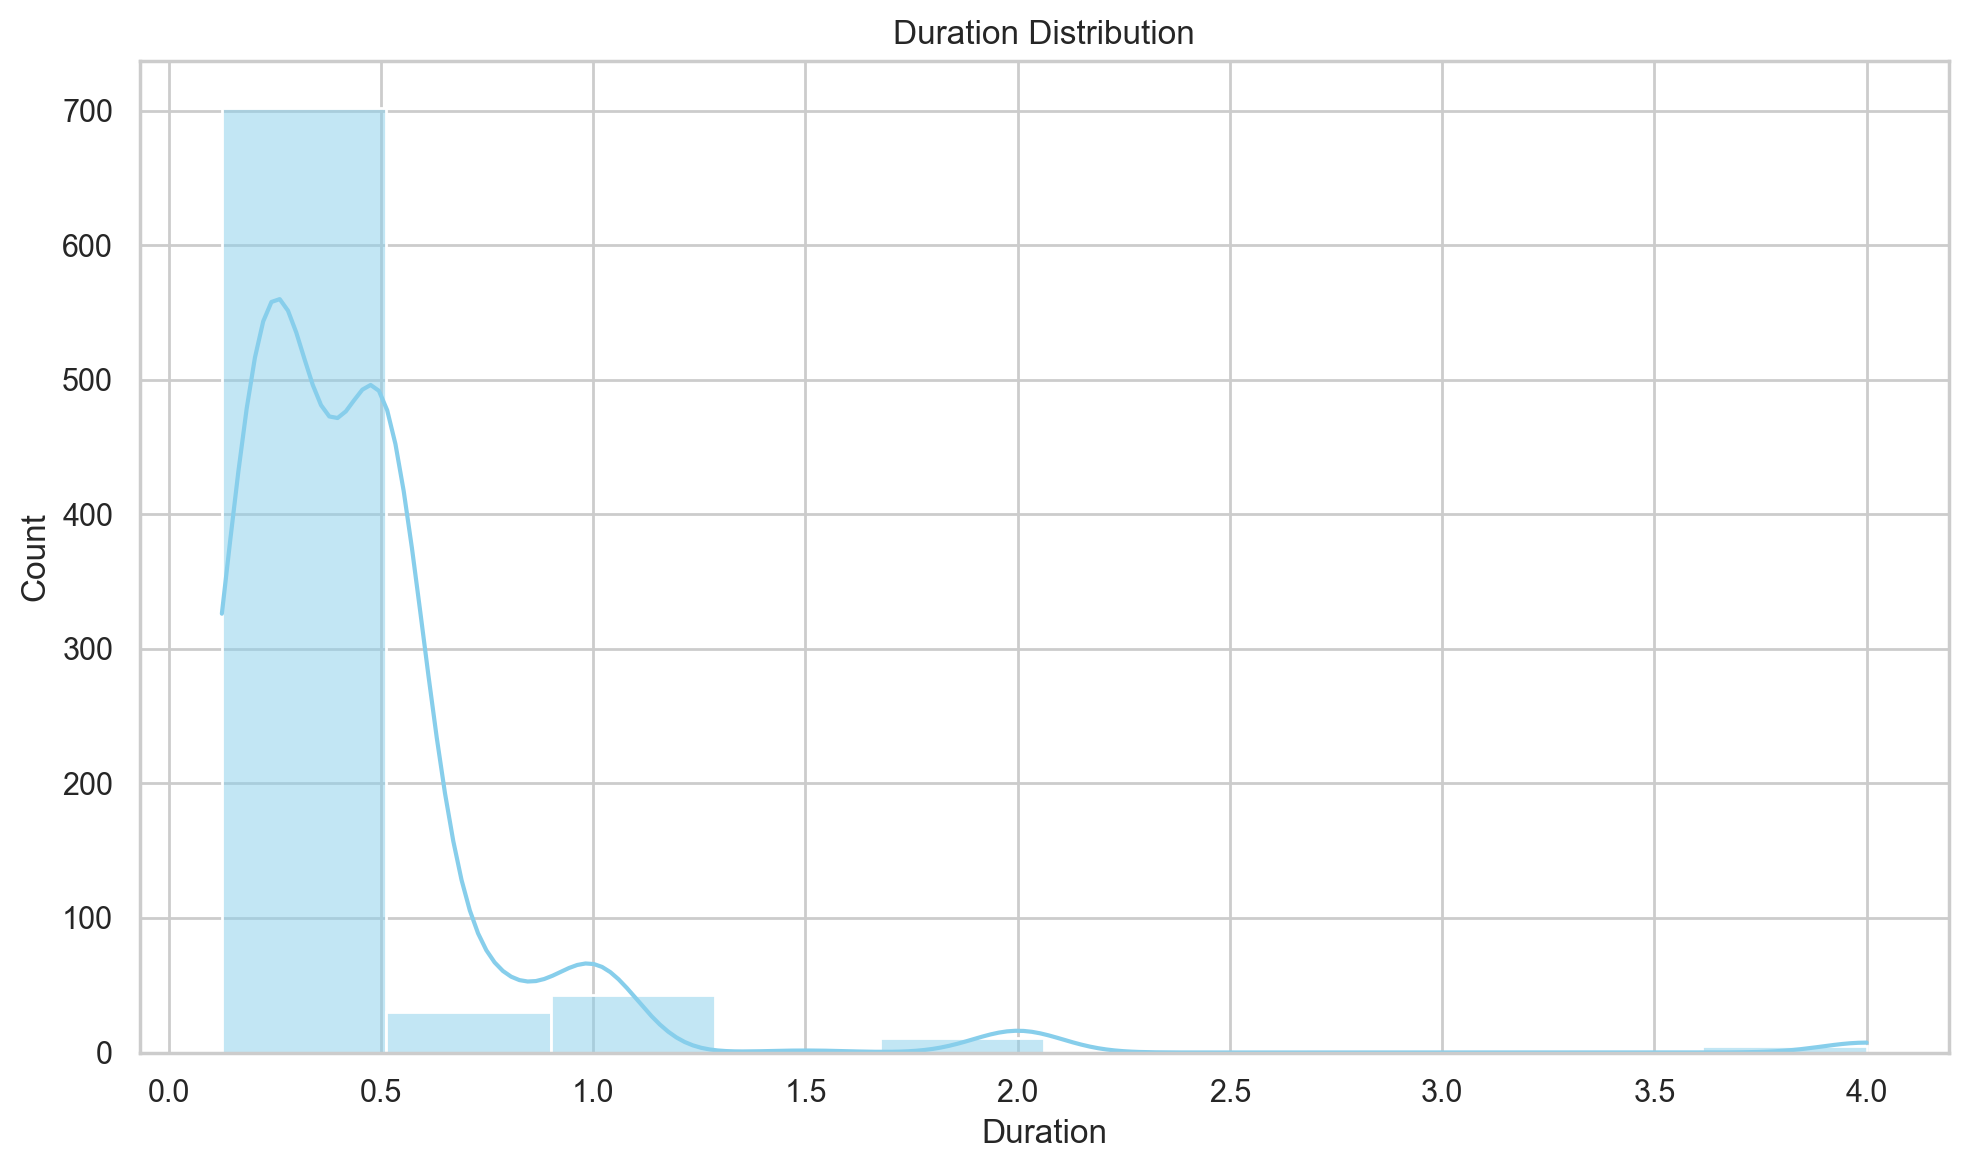

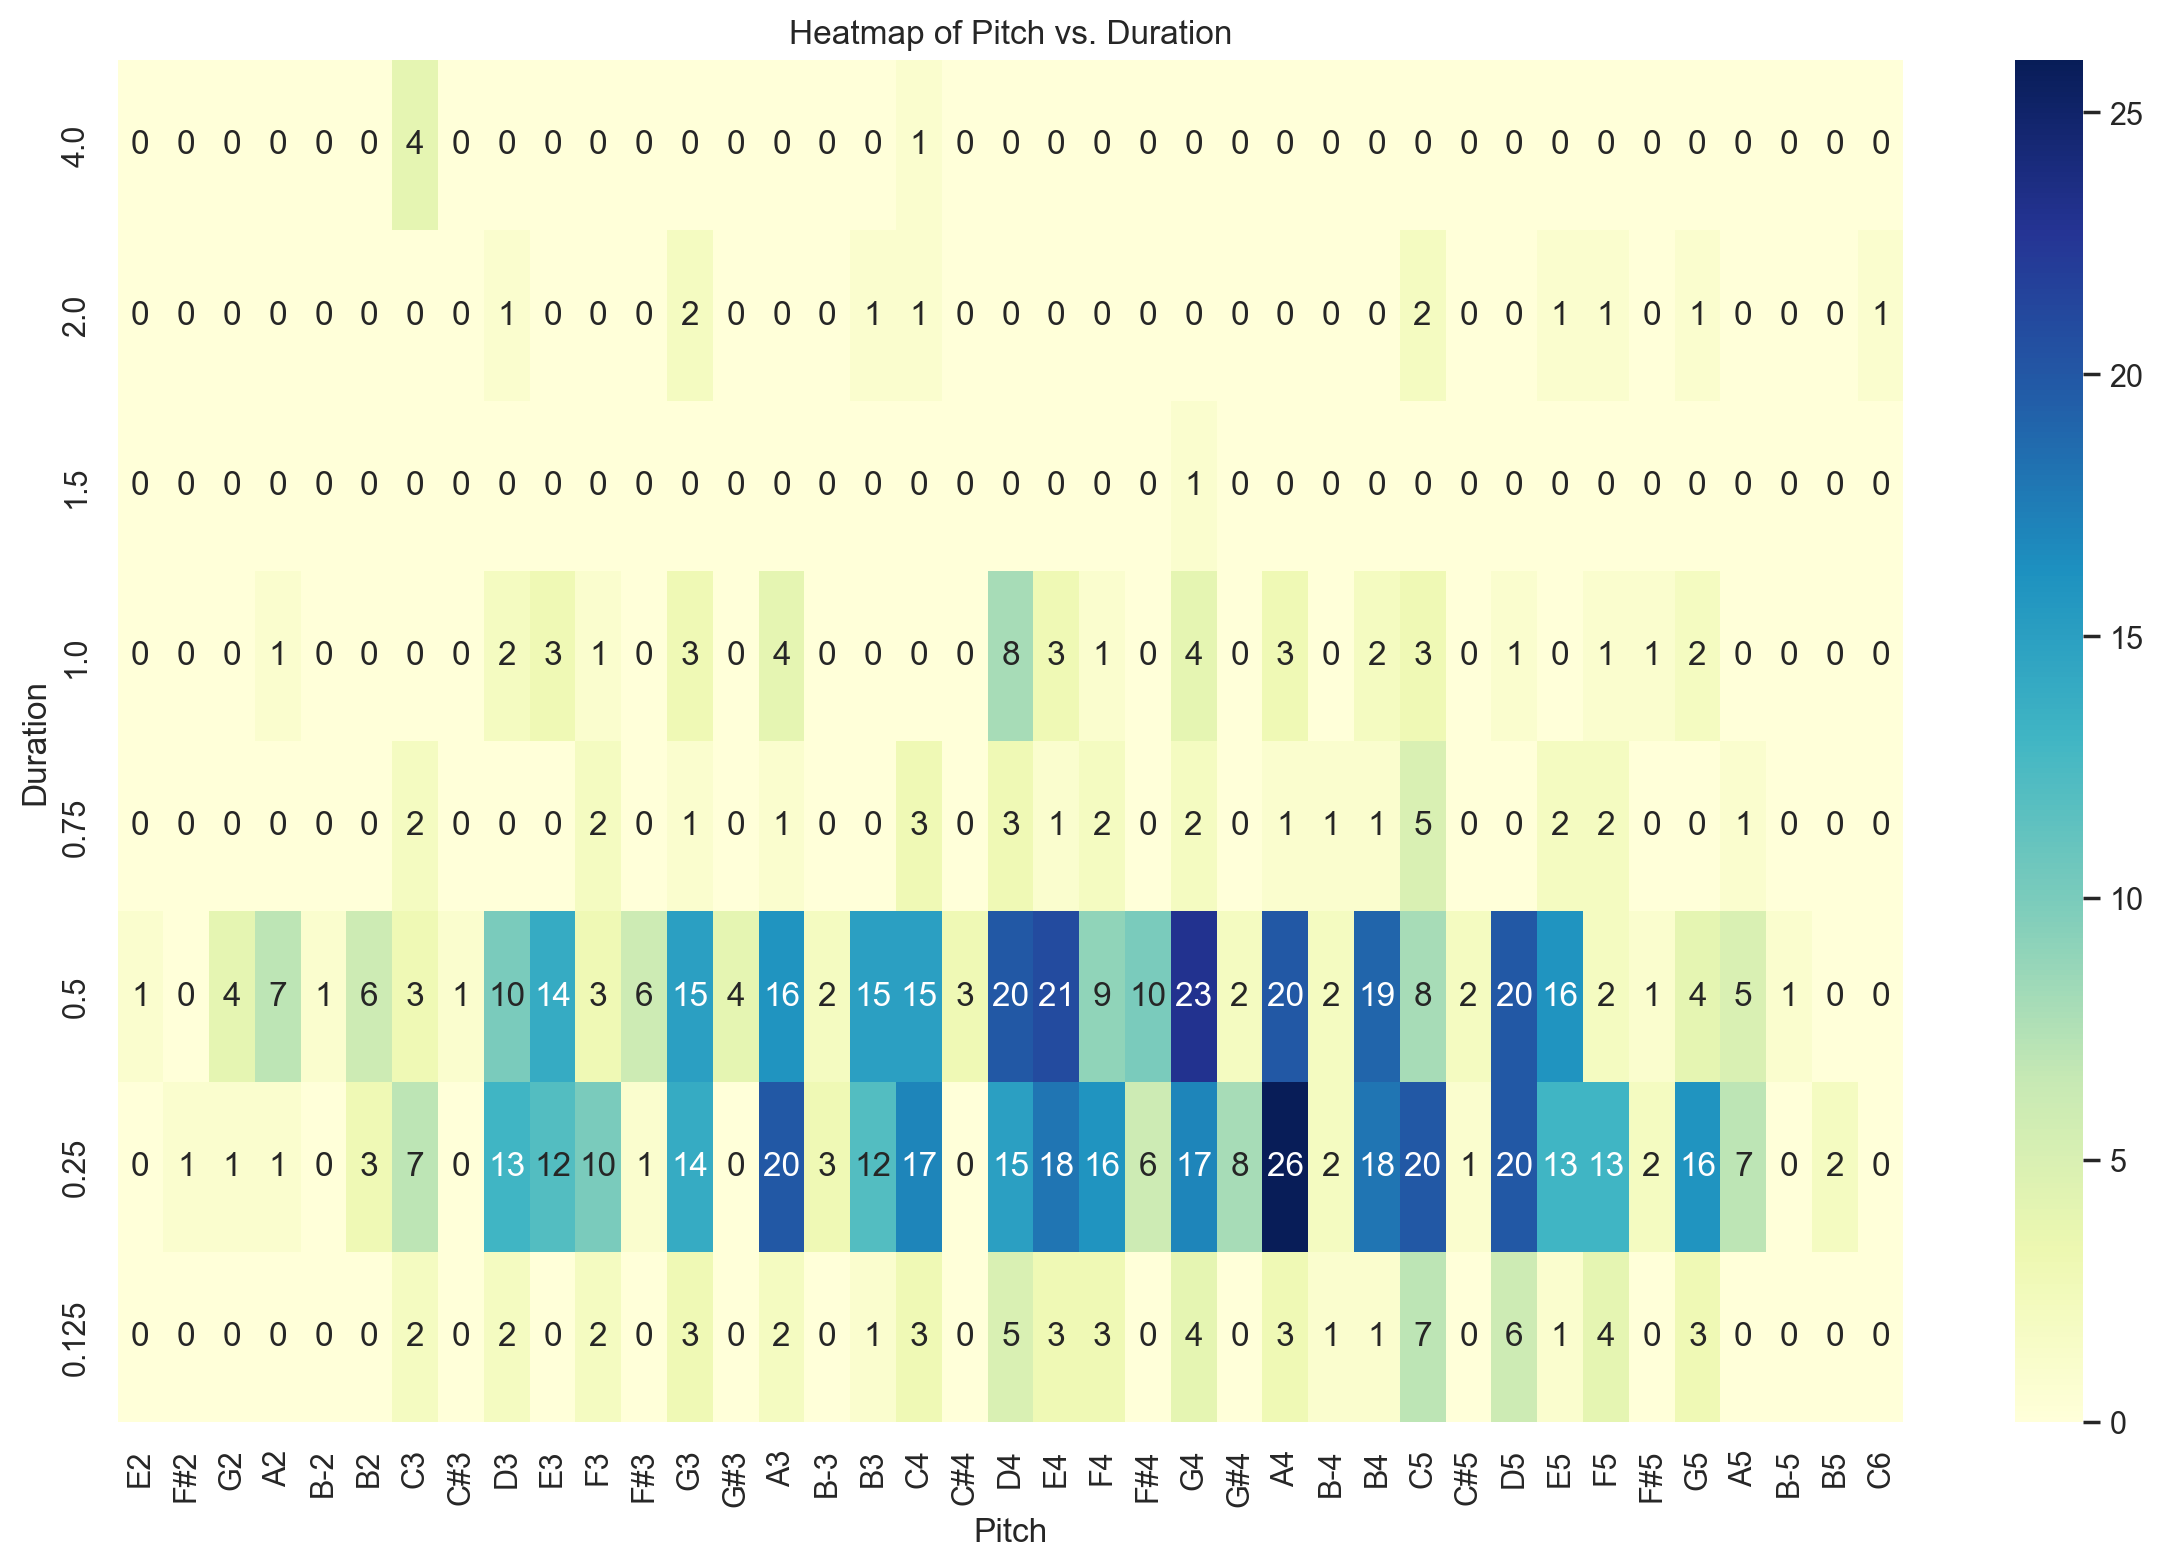

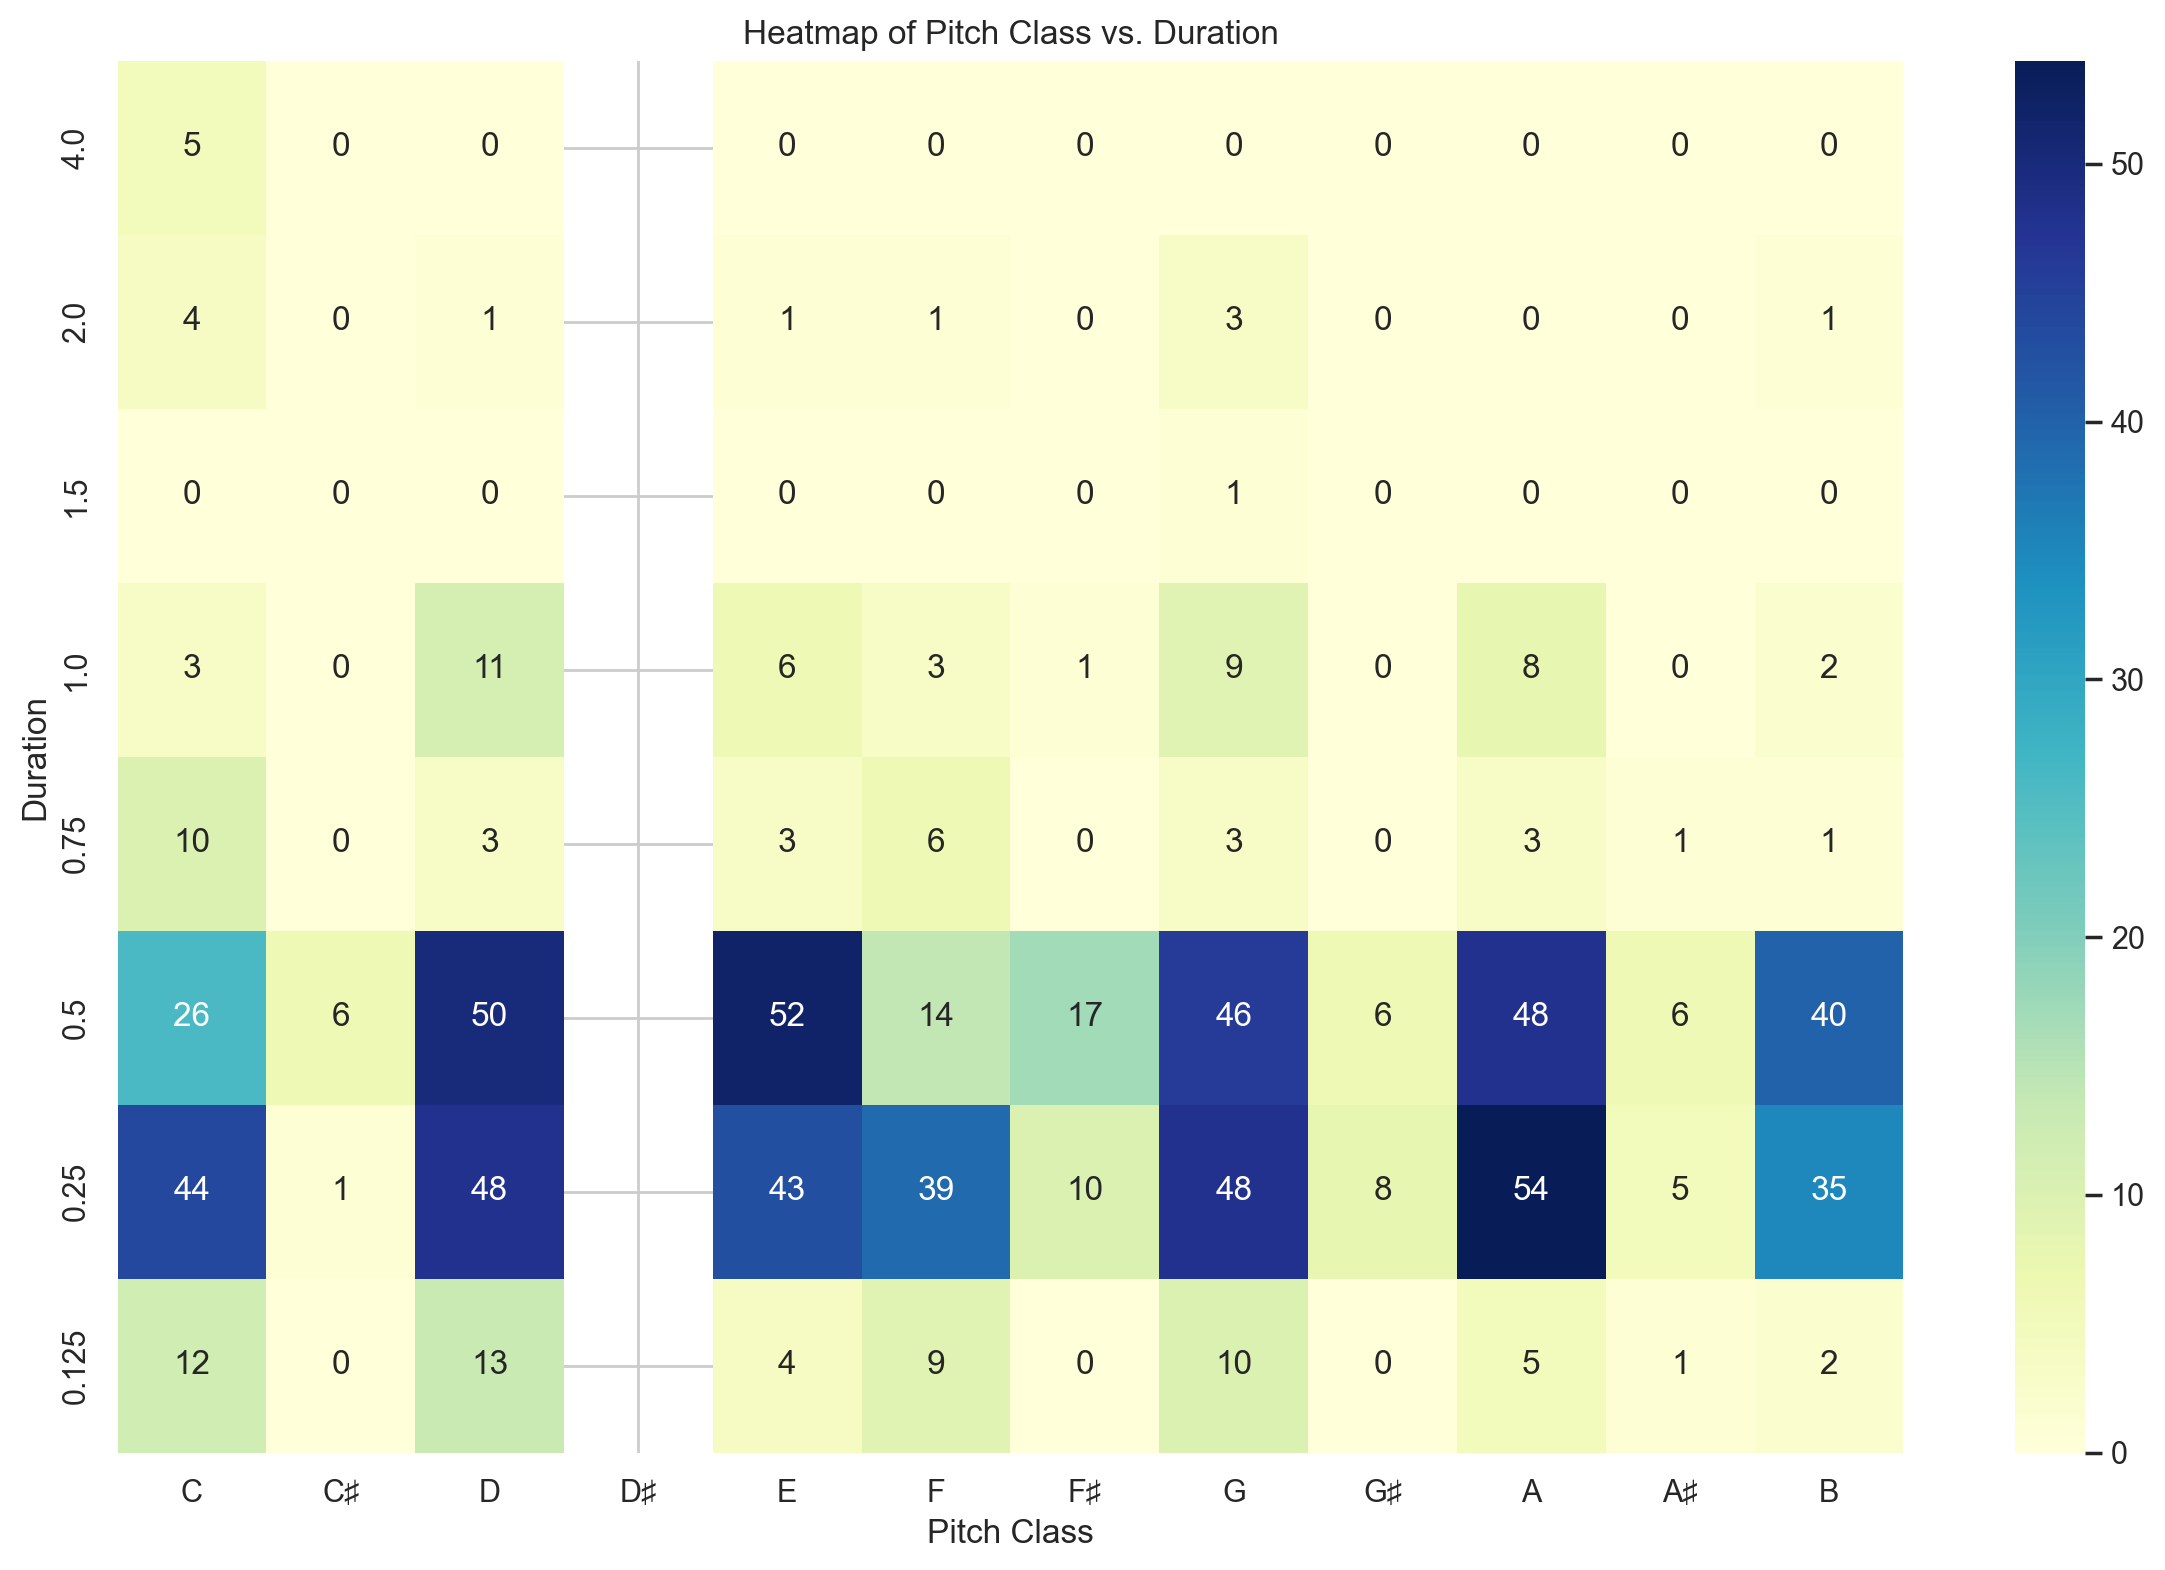

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define mapping from pitch class numbers to note names
PITCH_CLASS_MAPPING = {
    0: 'C',
    1: 'C♯',
    2: 'D',
    3: 'D♯',
    4: 'E',
    5: 'F',
    6: 'F♯',
    7: 'G',
    8: 'G♯',
    9: 'A',
    10: 'A♯',
    11: 'B'
}

# Function to extract pitch class from MIDI
def get_pitch_class_from_midi(midi_number):
    """Extract the pitch class from the MIDI number."""
    return PITCH_CLASS_MAPPING[midi_number % 12]

# Add Pitch Class column based on MIDI
df['Pitch Class'] = df['MIDI'].apply(get_pitch_class_from_midi)

# Set global style for seaborn
sns.set(style='whitegrid')

# Define Pitch Order Based on MIDI Values
pitch_order = (df[['Pitch', 'MIDI']]
               .drop_duplicates()
               .sort_values('MIDI')['Pitch']
               .tolist())

pitch_class_order = ['C', 'C♯', 'D', 'D♯', 'E', 'F', 'F♯', 'G', 'G♯', 'A', 'A♯', 'B']

# **1. Pitch Distribution**

def plot_pitch_distribution(df, pitch_order):
    """Plot the distribution of pitches."""
    pitch_counts = df['Pitch'].value_counts().reindex(pitch_order).fillna(0)
    pitch_df = pitch_counts.reset_index()
    pitch_df.columns = ['Pitch', 'Frequency']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=pitch_df, x='Pitch', y='Frequency', hue='Pitch', palette='viridis', dodge=False, legend=False)
    plt.title('Pitch Distribution')
    plt.xlabel('Pitch')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# **2. Pitch Class Distribution**

def plot_pitch_class_distribution(df, pitch_class_order):
    """Plot the distribution of pitch classes."""
    pitch_class_counts = df['Pitch Class'].value_counts().reindex(pitch_class_order).fillna(0)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=pitch_class_counts.index, y=pitch_class_counts.values, palette='magma', hue=pitch_class_counts.index, dodge=False, legend=False)
    plt.title('Pitch Class Distribution')
    plt.xlabel('Pitch Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# **3. Duration Distribution**

def plot_duration_distribution(df):
    """Plot the distribution of durations."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Duration'], bins=10, kde=True, color='skyblue')
    plt.title('Duration Distribution')
    plt.xlabel('Duration')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# **4. Heatmap of Pitch vs. Duration (Flipped Axes, Durations Ordered)**

def plot_pitch_duration_heatmap(df, pitch_order):
    """Plot a heatmap of Pitch vs. Duration with flipped axes (Pitches on X-axis) and durations ordered from smallest to highest."""
    heatmap_data = (df.pivot_table(index='Duration', columns='Pitch', values='MIDI', aggfunc='count')
                    .fillna(0)
                    .reindex(columns=pitch_order))

    heatmap_data = heatmap_data.sort_index(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Heatmap of Pitch vs. Duration')
    plt.xlabel('Pitch')
    plt.ylabel('Duration')
    plt.tight_layout()
    plt.show()

# **5. Heatmap of Pitch Class vs. Duration**

def plot_pitch_class_duration_heatmap(df, pitch_class_order):
    """Plot a heatmap of Pitch Class vs. Duration with flipped axes (Pitch Classes on X-axis) and durations ordered from smallest to highest."""
    heatmap_data = (df.pivot_table(index='Duration', columns='Pitch Class', values='MIDI', aggfunc='count')
                    .fillna(0)
                    .reindex(columns=pitch_class_order))

    heatmap_data = heatmap_data.sort_index(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Heatmap of Pitch Class vs. Duration')
    plt.xlabel('Pitch Class')
    plt.ylabel('Duration')
    plt.tight_layout()
    plt.show()

# Call the functions
plot_pitch_distribution(df, pitch_order)
plot_pitch_class_distribution(df, pitch_class_order)
plot_duration_distribution(df)
plot_pitch_duration_heatmap(df, pitch_order)
plot_pitch_class_duration_heatmap(df, pitch_class_order)


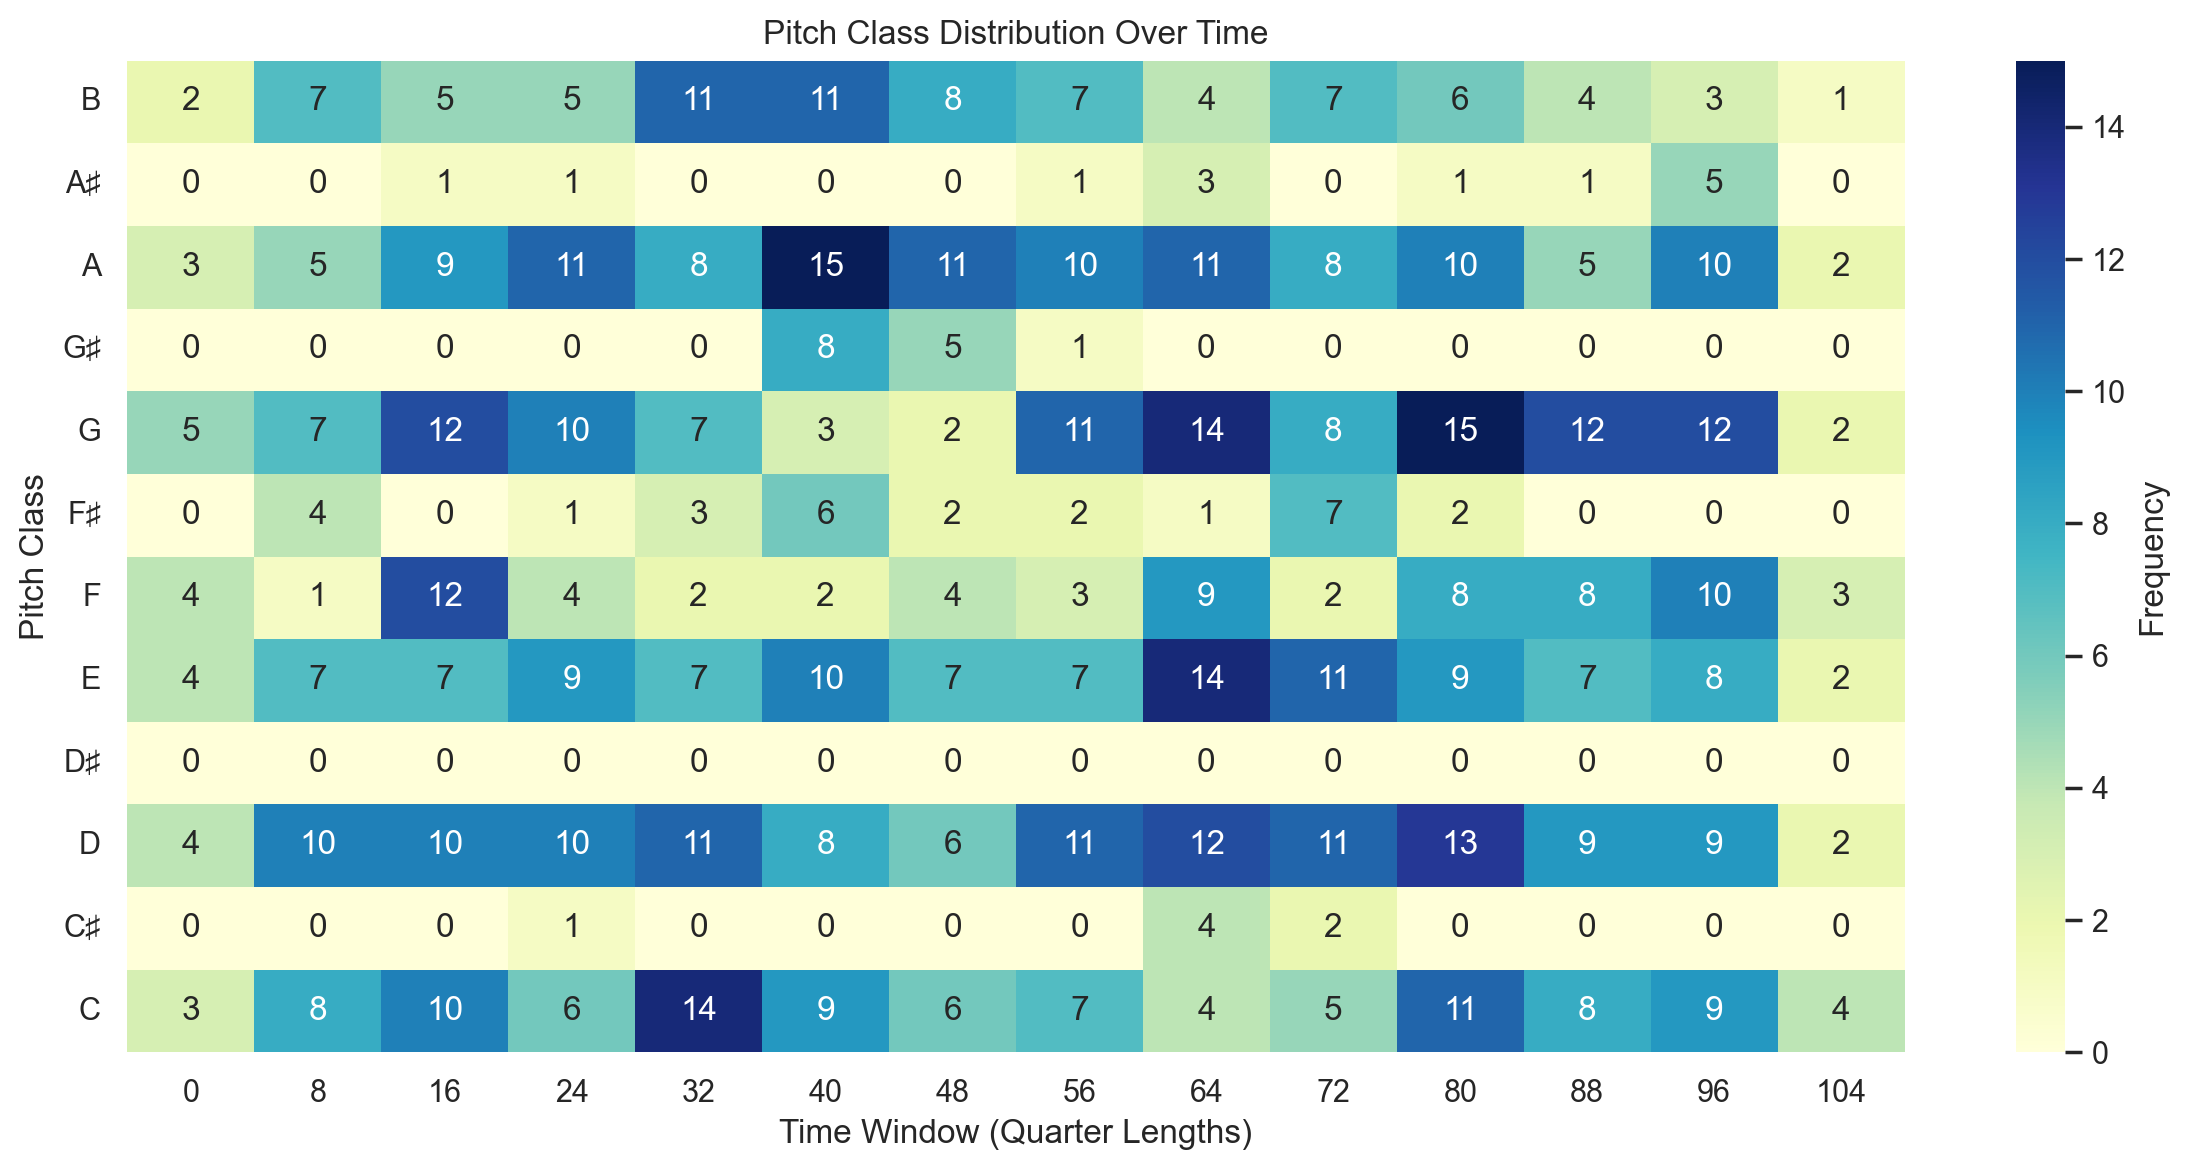

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Pitch Class' is correctly calculated based on MIDI
df['Pitch Class'] = df['MIDI'].apply(lambda x: PITCH_CLASS_MAPPING[x % 12])

# **Step 1: Define Time Windows**

# Determine the maximum time to set the range for windows
max_time = df['Global Onset'].max() + df['Duration'].max()

# Define the window size (1 quarter length)
window_size = 8.0

# Create window edges
window_edges = np.arange(0, max_time + window_size, window_size)

# Assign each note to a window based on its 'Global Onset'
df['Time Window'] = pd.cut(df['Global Onset'], bins=window_edges, right=False, labels=window_edges[:-1])

# **Step 2: Compute Pitch Class Distribution for Each Window**

# Pivot table to count occurrences of each pitch class in each window
pitch_distribution = pd.crosstab(df['Time Window'], df['Pitch Class'])

# Reindex the columns to ensure all pitch classes are present and in order
pitch_class_order = ['C', 'C♯', 'D', 'D♯', 'E', 'F', 'F♯', 'G', 'G♯', 'A', 'A♯', 'B']
pitch_distribution = pitch_distribution.reindex(columns=pitch_class_order, fill_value=0)

# **Step 3: Create a Heatmap**

plt.figure(figsize=(12, 6))

# Flip the pitch class order to reverse the y-axis
pitch_class_order_flipped = pitch_class_order[::-1]

# Create the heatmap with flipped y-axis
sns.heatmap(pitch_distribution.T.loc[pitch_class_order_flipped], cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Frequency'})

plt.title('Pitch Class Distribution Over Time')
plt.xlabel('Time Window (Quarter Lengths)')
plt.ylabel('Pitch Class')

# Set xticks and yticks
plt.xticks(ticks=np.arange(len(window_edges)-1)+0.5, labels=[f"{int(edge)}" for edge in window_edges[:-1]], rotation=0)
plt.yticks(ticks=np.arange(len(pitch_class_order_flipped))+0.5, labels=pitch_class_order_flipped, rotation=0)

plt.tight_layout()
plt.show()


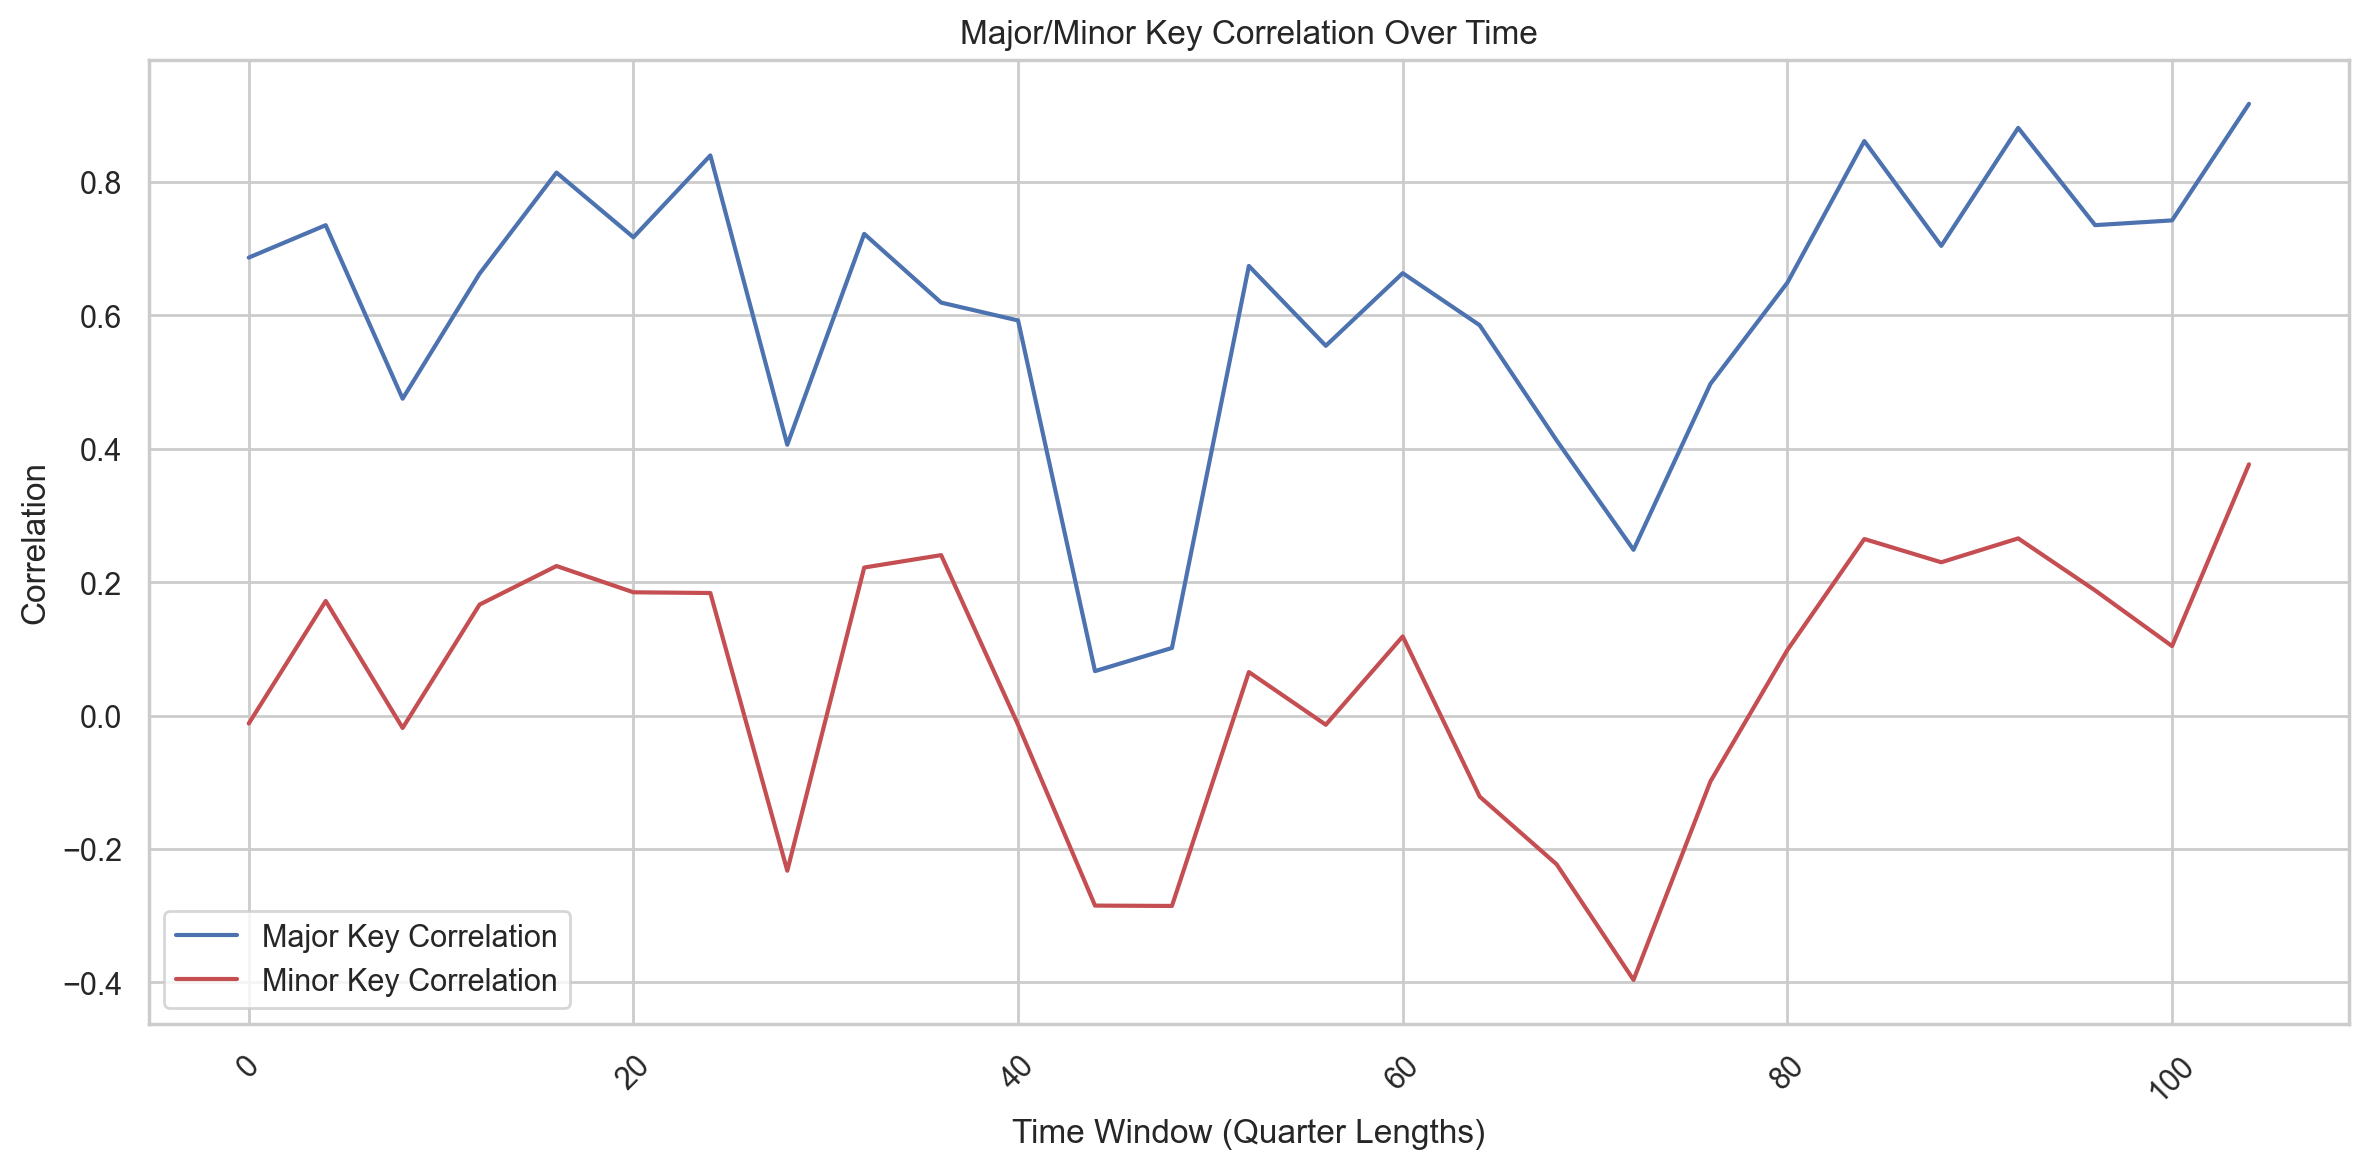

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example Krumhansl-Kessler key profiles
major_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
minor_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

# **Step 1: Define Time Windows**

# Assuming df is already pre-processed as before
# df['Pitch Class'] and 'Global Onset' columns exist

# Ensure 'Pitch Class' is correctly calculated based on MIDI
df['Pitch Class'] = df['MIDI'].apply(lambda x: PITCH_CLASS_MAPPING[x % 12])

# Determine the maximum time to set the range for windows
max_time = df['Global Onset'].max() + df['Duration'].max()

# Define the window size (1 quarter length)
window_size = 4.0

# Create window edges
window_edges = np.arange(0, max_time + window_size, window_size)

# Assign each note to a window based on its 'Global Onset'
df['Time Window'] = pd.cut(df['Global Onset'], bins=window_edges, right=False, labels=window_edges[:-1])

# **Step 2: Compute Pitch Class Distribution for Each Window**

# Pivot table to count occurrences of each pitch class in each window
pitch_distribution = pd.crosstab(df['Time Window'], df['Pitch Class'])

# Reindex the columns to ensure all pitch classes are present and in order
pitch_class_order = ['C', 'C♯', 'D', 'D♯', 'E', 'F', 'F♯', 'G', 'G♯', 'A', 'A♯', 'B']
pitch_distribution = pitch_distribution.reindex(columns=pitch_class_order, fill_value=0)

# **Step 3: Calculate Correlation with Key Profiles**

# Function to calculate correlation with a profile
def calculate_correlation(distribution, profile):
    # Normalize both the distribution and the profile
    norm_distribution = (distribution - np.mean(distribution)) / np.std(distribution)
    norm_profile = (profile - np.mean(profile)) / np.std(profile)
    return np.dot(norm_distribution, norm_profile) / (len(profile))

# Calculate the correlations for each window with the major and minor profiles
major_correlations = []
minor_correlations = []

for index, row in pitch_distribution.iterrows():
    row_values = row.values
    major_correlation = calculate_correlation(row_values, major_profile)
    minor_correlation = calculate_correlation(row_values, minor_profile)
    major_correlations.append(major_correlation)
    minor_correlations.append(minor_correlation)

# **Step 4: Plot the Correlations**

# Create a DataFrame to store the correlations for plotting
correlation_df = pd.DataFrame({
    'Time Window': pitch_distribution.index,
    'Major Correlation': major_correlations,
    'Minor Correlation': minor_correlations
})

# Plot the correlations over time
plt.figure(figsize=(12, 6))
plt.plot(correlation_df['Time Window'], correlation_df['Major Correlation'], label='Major Key Correlation', color='b')
plt.plot(correlation_df['Time Window'], correlation_df['Minor Correlation'], label='Minor Key Correlation', color='r')
plt.title('Major/Minor Key Correlation Over Time')
plt.xlabel('Time Window (Quarter Lengths)')
plt.ylabel('Correlation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


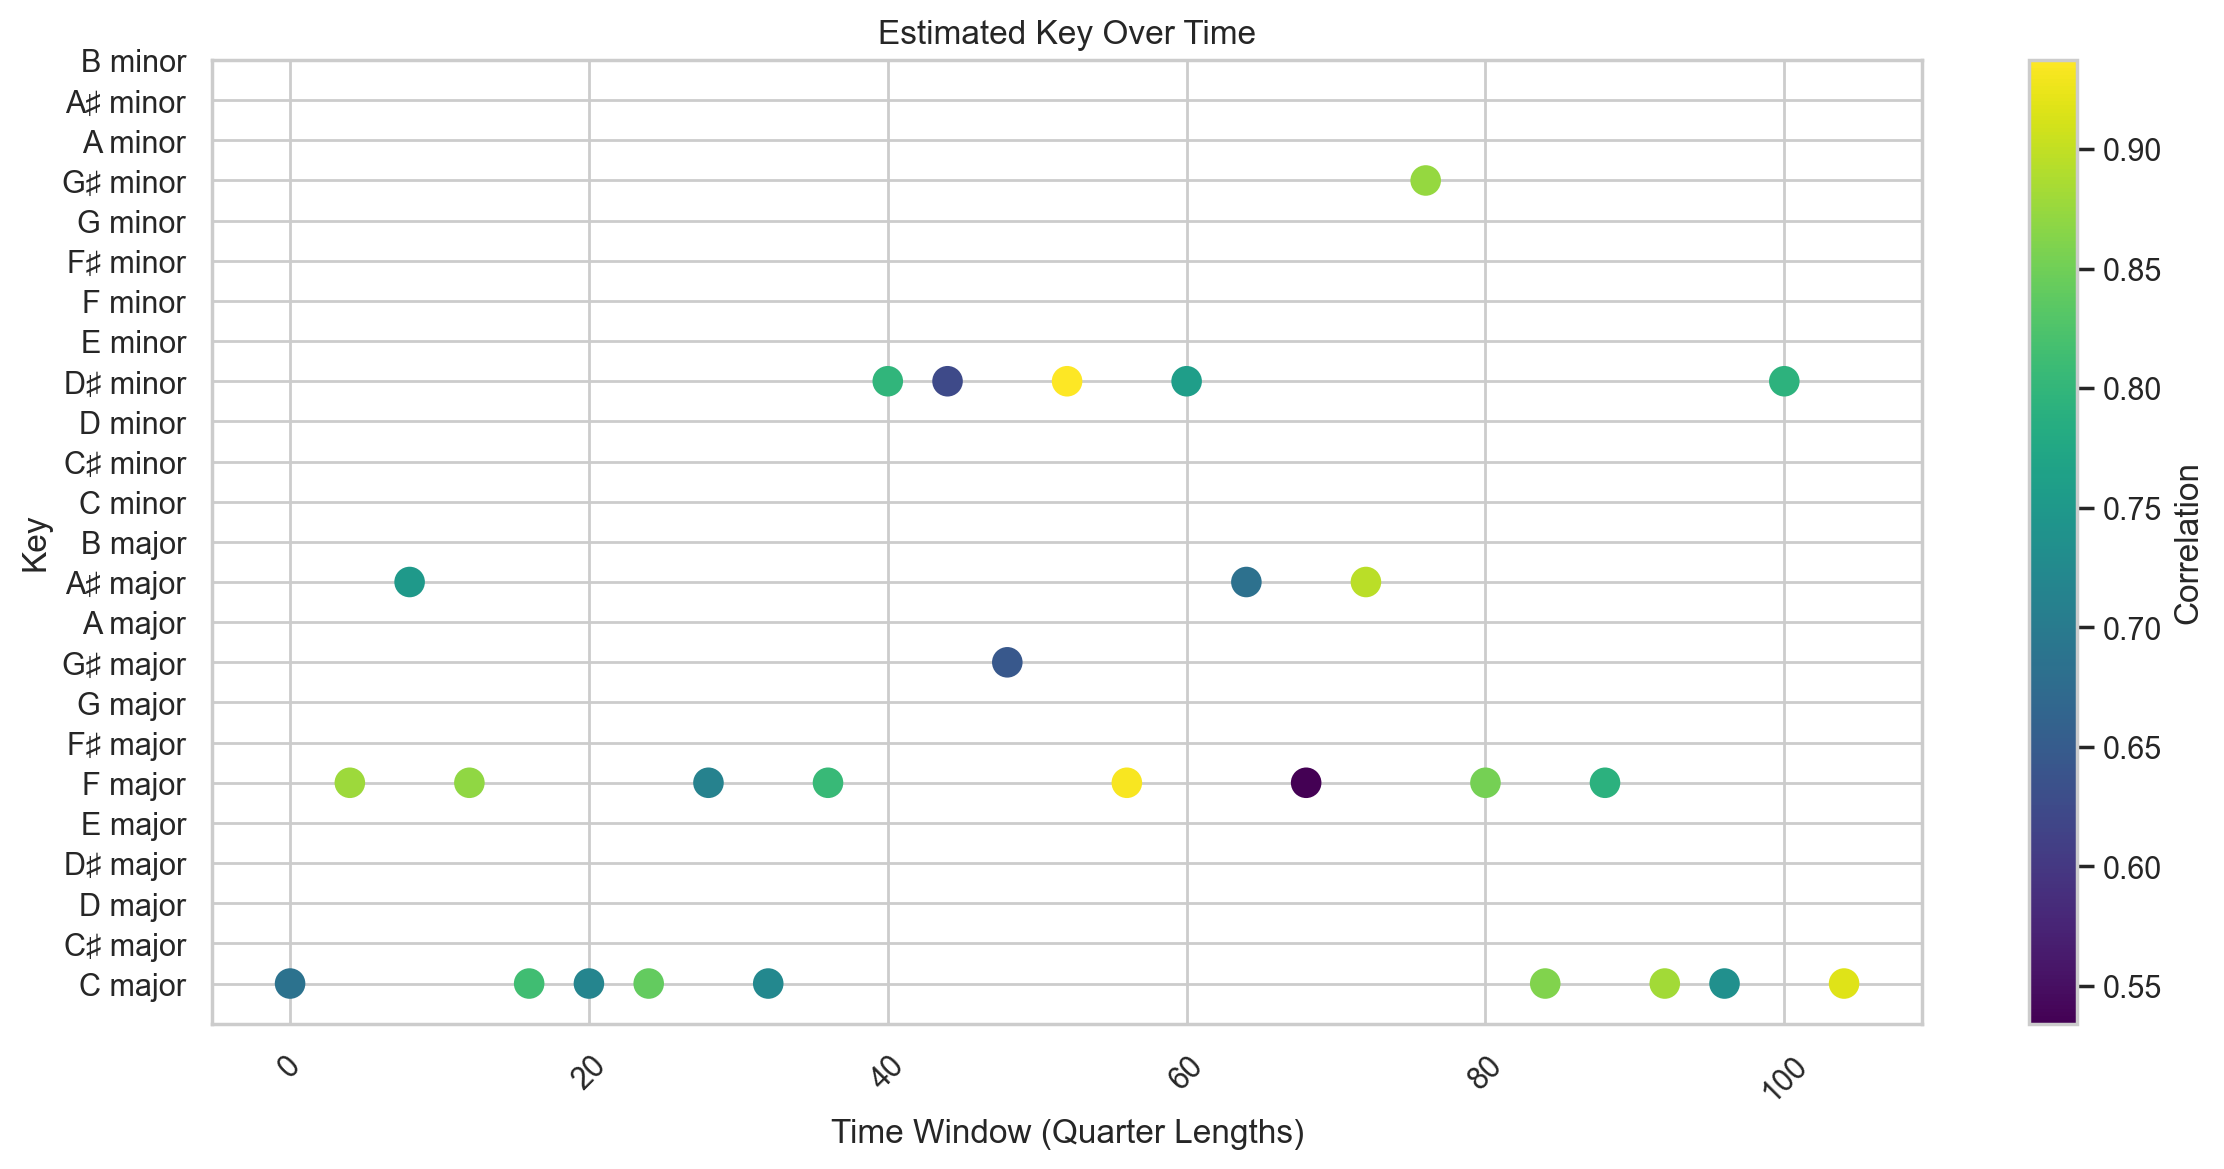

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already pre-processed and includes 'MIDI' and 'Global Onset' columns
# Also assuming PITCH_CLASS_MAPPING is defined as before
PITCH_CLASS_MAPPING = {0: 'C', 1: 'C♯', 2: 'D', 3: 'D♯', 4: 'E', 5: 'F', 6: 'F♯',
                       7: 'G', 8: 'G♯', 9: 'A', 10: 'A♯', 11: 'B'}

# Ensure 'Pitch Class' is correctly calculated based on MIDI
df['Pitch Class'] = df['MIDI'].apply(lambda x: PITCH_CLASS_MAPPING[x % 12])

# **Step 1: Define Time Windows**

# Determine the maximum time to set the range for windows
max_time = df['Global Onset'].max() + df['Duration'].max()

# Define the window size (e.g., 8 quarter lengths)
window_size = 4.0

# Create window edges
window_edges = np.arange(0, max_time + window_size, window_size)

# Assign each note to a window based on its 'Global Onset'
df['Time Window'] = pd.cut(df['Global Onset'], bins=window_edges, right=False, labels=window_edges[:-1])

# **Step 2: Compute Pitch Class Distribution for Each Window**

# Pivot table to count occurrences of each pitch class in each window
pitch_distribution = pd.crosstab(df['Time Window'], df['Pitch Class'])

# Reindex the columns to ensure all pitch classes are present and in order
pitch_class_order = ['C', 'C♯', 'D', 'D♯', 'E', 'F', 'F♯', 'G', 'G♯', 'A', 'A♯', 'B']
pitch_distribution = pitch_distribution.reindex(columns=pitch_class_order, fill_value=0)

# **Step 3: Generate Rotated Key Profiles**

# Krumhansl-Kessler key profiles
major_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]

minor_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

# Generate key profiles for all 24 keys
keys = []
key_profiles = []

# For major keys
for i in range(12):
    key_name = pitch_class_order[i] + ' major'
    # Rotate the major profile
    profile = np.roll(major_profile, -i)
    keys.append(key_name)
    key_profiles.append(profile)

# For minor keys
for i in range(12):
    key_name = pitch_class_order[i] + ' minor'
    # Rotate the minor profile
    profile = np.roll(minor_profile, -i)
    keys.append(key_name)
    key_profiles.append(profile)

# **Step 4: Calculate Correlations with Key Profiles**

best_keys = []
best_correlations = []

for index, row in pitch_distribution.iterrows():
    row_values = row.values.astype(float)
    # Normalize the pitch class distribution
    if np.std(row_values) == 0:
        norm_distribution = row_values - np.mean(row_values)
    else:
        norm_distribution = (row_values - np.mean(row_values)) / np.std(row_values)

    correlations = []
    for profile in key_profiles:
        # Normalize the key profile
        norm_profile = (profile - np.mean(profile)) / np.std(profile)
        # Compute the correlation
        correlation = np.dot(norm_distribution, norm_profile) / len(profile)
        correlations.append(correlation)

    # Find the index of the maximum correlation
    max_index = np.argmax(correlations)
    best_key = keys[max_index]
    best_correlation = correlations[max_index]
    best_keys.append(best_key)
    best_correlations.append(best_correlation)

# **Step 5: Create a DataFrame to Store the Results**

key_df = pd.DataFrame({
    'Time Window': pitch_distribution.index,
    'Best Key': best_keys,
    'Correlation': best_correlations
})

# **Step 6: Visualize the Estimated Keys Over Time**

# Create a mapping from key names to numerical values for plotting
key_to_num = {key: i for i, key in enumerate(keys)}
num_to_key = {i: key for i, key in enumerate(keys)}

# Map best keys to numerical values
key_nums = [key_to_num[key] for key in best_keys]
key_df['Key Num'] = key_nums

plt.figure(figsize=(12, 6))
plt.scatter(key_df['Time Window'], key_df['Key Num'], c=key_df['Correlation'], cmap='viridis', s=100)
plt.colorbar(label='Correlation')

plt.yticks(ticks=range(len(keys)), labels=keys)
plt.xticks(rotation=45)
plt.title('Estimated Key Over Time')
plt.xlabel('Time Window (Quarter Lengths)')
plt.ylabel('Key')
plt.tight_layout()
plt.show()
